# Chapter 23. Principal Components Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import fft, ifft
import firls
from scipy.signal import filtfilt

ModuleNotFoundError: No module named 'firls'

In [ ]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

### Figure 23.2

In [3]:
# compute erp, subtract mean, compute cov
erp = EEGdata.mean(2).squeeze()
erp -= erp.mean(1)[:, np.newaxis]

covar = (erp @ erp.T)/(EEGpnts - 1)  # unbiased

fig, ax = plt.subplots(1,3, figsize=[8,3], tight_layout=True)
im0 = ax[0].imshow(covar)
ax[0].set(title='cov of erp')

# one cov of all time points
eeg = np.reshape(EEGdata, (EEGnbchan, EEGpnts*EEGtrials), order='f')
eeg -= eeg.mean(1)[:, np.newaxis]
covar = np.cov(eeg)
im1 = ax[1].imshow(covar)
ax[1].set(title='cov of single trial eeg')

# avg of single trial covs
covar = np.zeros(EEGnbchan)
for i in range(EEGtrials):
    eeg = EEGdata[...,i] - EEGdata[...,i].mean(1)[:, np.newaxis]
    covar = covar + np.cov(eeg)

covar /= i
ax[2].imshow(covar)
ax[2].set(title='avg cov of single-trial eeg')

fig.tight_layout()

NameError: name 'EEGdata' is not defined

### Figure 23.3
This requires topoplot.
I might try later to just do a surface laplacian and leave it as a contour plot.

#TODO

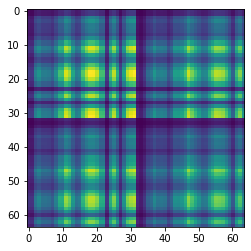

In [43]:
# compute cov of erp

erp = EEGdata.mean(2)
erp -= erp.mean(1)[:,np.newaxis]
covar = np.cov(erp)

v, d, _ = np.linalg.svd(covar)  # compute pca

### Figure 23.4
Also needs topoplot

### Figure 23.5

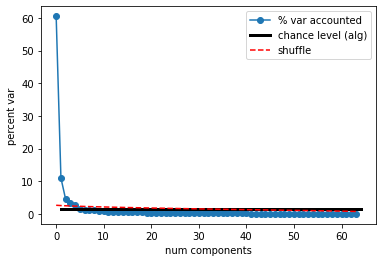

In [81]:
covar = np.zeros((EEGnbchan, EEGnbchan))

for i in range(EEGtrials):
    eeg = EEGdata[...,i] - EEGdata[...,i].mean(1)[:,np.newaxis]
    covar = covar + np.cov(eeg)

covar = covar/i

pc, eigvals, _ = np.linalg.svd(covar)
eigvals = 100*eigvals/sum(eigvals)

plt.plot(eigvals, '-o', label='% var accounted')
plt.plot([1, EEGnbchan], [100/EEGnbchan]*2, 'k', label='chance level (alg)', linewidth=3)

# amount of var expected by chance computed based on rand data
nperms = 100
permeigvals = np.zeros((nperms, EEGnbchan))

for permi in range(nperms):
    randdat = np.random.permutation(erp.flatten())
    randdat = np.reshape(randdat, (EEGnbchan, EEGpnts))
    covar = np.cov(randdat)
    pc, eigvals,_ = np.linalg.svd(covar)
    permeigvals[permi] = 100*eigvals/sum(eigvals)

plt.plot(permeigvals.mean(0), 'r--', label='shuffle')
plt.xlabel('num components')
plt.ylabel('percent var')
plt.legend()

### Figure 23.6, 23.7
Also requires topoplot

In [19]:

center_freq = 12
filter_frequency_spread = 3
transition_width = 0.2

# construct kernel
nyquist = EEGsrate/2
filter_order = int(3*(EEGsrate/(center_freq - filter_frequency_spread)))
ffrequencies = np.array([0,
                        (1-transition_width)*(center_freq-filter_frequency_spread),
                        (center_freq - filter_frequency_spread),
                        (center_freq + filter_frequency_spread),
                        (1 + transition_width)*(center_freq+filter_frequency_spread),
                        nyquist])/nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = scipy.signal.firls(filter_order, list(ffrequencies), idealresponse)

filter_result = scipy.signal.filtfilt(filterweights, 1,
                                      np.reshape(EEGdata, (EEGnbchan, EEGpnts* EEGtrials), order='f'))
filter_result = np.reshape(filter_result, (EEGnbchan, EEGpnts, EEGtrials), 'F')

### Figure 23.8

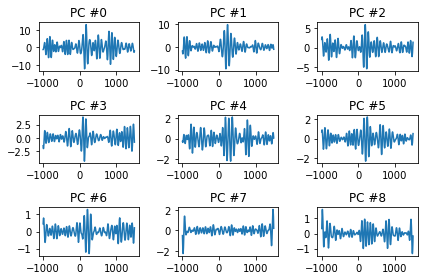

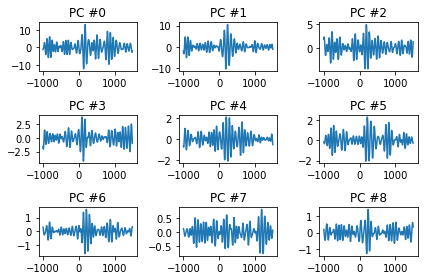

In [28]:
covar = np.zeros(EEGnbchan)
for i in range(30):
    eeg = filter_result[...,i] - filter_result[...,0].mean(1)[:, np.newaxis]
    covar = covar + np.cov(eeg)
covar /= i

pc, eigvals, _ = np.linalg.svd(covar)

fig, ax = plt.subplots(3,3)
for i in range(9):
   idx = np.unravel_index(i, (3,3))
   ax[idx].plot(EEGtimes, pc[:,i]@filter_result[...,:30].mean(2))
   ax[idx].set(title=f'PC #{i}')
fig.tight_layout()

# pca on last 30 trials
covar = np.zeros((EEGnbchan, EEGnbchan))
for i in range(EEGtrials-30, EEGtrials):
    eeg = filter_result[...,i] - filter_result[...,i].mean(1)[:,np.newaxis]
    covar = covar + np.cov(eeg)
covar /= 30

pc, eigvals, _ = np.linalg.svd(covar)

fig, ax = plt.subplots(3,3)
for i in range(9):
   idx = np.unravel_index(i, (3,3))
   ax[idx].plot(EEGtimes, pc[:,i]@filter_result[...,:30].mean(2))
   ax[idx].set(title=f'PC #{i}')
fig.tight_layout()
